In [10]:
%load_ext pycodestyle_magic
%flake8_on
import librosa
import glob
from IPython.display import Audio
import os
import numpy as np
from pylab import *
import tqdm
from scipy.io import wavfile


def save_scp(dst_name, scp):
    with open(dst_name, 'wt') as f:
        f.write('\n'.join(scp))

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [11]:
wav_files = glob.glob('./data/Train_speech/*/*.wav')
wav_files.sort()
txt_files = [f+'.txt' for f in wav_files]
dst_folder = './data/train_split/'
os.makedirs(dst_folder, exist_ok=True)

In [12]:
file_idx = 0
pbar = tqdm.tqdm_notebook(total=len(wav_files))
wav_scp = []
spk_scp = []
seg_scp = []
text_scp = []
orig_scp = []


for wav_file, txt_file in zip(wav_files, txt_files):
    pbar.update(1)
    r, s = wavfile.read(wav_file)
    assert r == 16000
    with open(txt_file) as f:
        lines = f.read().split('\n')
        for line in lines:
            toks = line.split('_')
            if len(toks) < 4:
                continue
            spk = toks[0]
            start = int(float(toks[1])*r)
            end = int(float(toks[2])*r)
            txt = toks[3]
            key = f'{file_idx:08}'
            dst_name = dst_folder + f'/{key}.wav'
            wav_scp +=[key+' '+dst_name]
            spk_scp += [key+' '+spk]
            seg_scp += [f'{key} {start}-{end}']
            orig_scp += [f'{key} {wav_file}']
            text_scp += [f'{key} {txt}']
            
            
            wavfile.write(dst_name, r, s[start:end,:])
            file_idx += 1
            

save_scp('./data/wav_scp.txt', wav_scp)
save_scp('./data/text_scp.txt', text_scp)
save_scp('./data/spk_scp.txt', spk_scp)
save_scp('./data/seg_scp.txt', seg_scp)
save_scp('./data/orig_scp.txt', orig_scp)
        

/media/sda1/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


25:23: E225 missing whitespace around operator
30:1: W293 blank line contains whitespace
31:1: W293 blank line contains whitespace
32:13: E303 too many blank lines (2)
32:51: E231 missing whitespace after ','
34:1: W293 blank line contains whitespace
41:1: W293 blank line contains whitespace


In [ ]:
tail da

In [18]:
def get_spk_dur(txt_file,spk2dur):
    lines = open(txt_file).read().split('\n')
    lines = [line for line in lines if len(line) > 0]
    # spk = [int(line.split('_')[0]) for line in lines]
    for line in lines:
        toks = line.split('_')
        spk = toks[0]
        dur = float(toks[2]) - float(toks[1])
        spk2dur[spk] += dur
    
    return spk2dur

1:25: E231 missing whitespace after ','
10:1: W293 blank line contains whitespace


In [4]:

def get_spk(txt_file):
    lines = open(txt_file).read().split('\n')
    lines = [line for line in lines if len(line) > 0]
    spk = [int(line.split('_')[0]) for line in lines]
    return spk
all_spk = []
n_spk_per_file=[]
for txt_file in txt_files:
    all_spk += get_spk(txt_file)
    n_spk_per_file += [len(set(get_spk(txt_file)))]

7:1: E305 expected 2 blank lines after class or function definition, found 0
8:15: E225 missing whitespace around operator


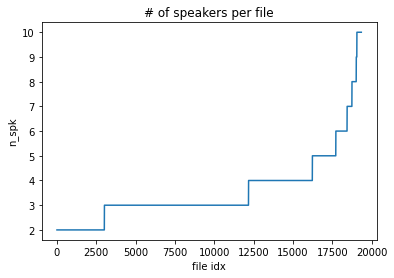

In [5]:
figure()
plot(np.sort(n_spk_per_file))
xlabel('file idx')
ylabel('n_spk')
title('# of speakers per file')
show()

In [6]:
spk_set = np.unique(all_spk)
spk_set = [str(s) for s in spk_set]
spk2dur = {s: 0 for s in spk_set}
for txt_file in txt_files:
    spk2dur = get_spk_dur(txt_file, spk2dur)


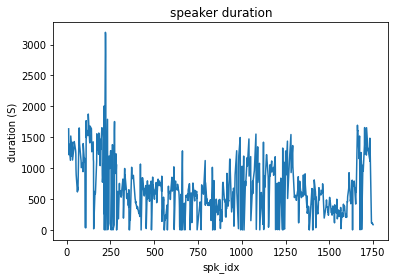

In [7]:
figure()
plot(np.unique(all_spk), spk2dur.values())
xlabel('spk_idx')
ylabel('duration (S)')
title('speaker duration')
show()

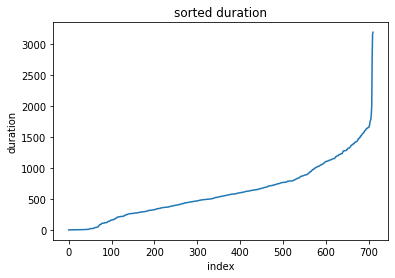

In [19]:
durs = np.array([v for v in spk2dur.values()])
durs.sort()
figure()
plot(durs)
xlabel('index')
ylabel('duration')
title('sorted duration')
show()


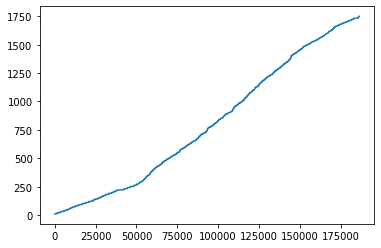

In [21]:
all_spk = np.sort(all_spk)
plot(all_spk)

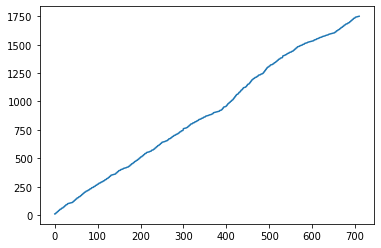

In [22]:
plot(np.unique(all_spk))

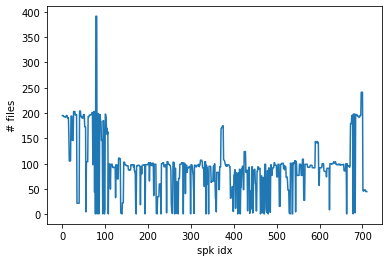

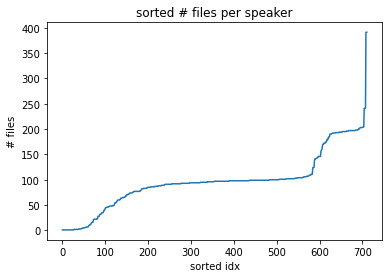

In [23]:
def get_spk_file(txt_file, spk2file):
    lines = open(txt_file).read().split('\n')
    lines = [line for line in lines if len(line) > 0]
    for line in lines:
        toks = line.split('_')
        spk = toks[0]
        spk2file[spk] += [txt_file]
    return spk2file


spk_set = np.unique(all_spk)
spk_set = [str(s) for s in spk_set]
spk2file = {s: [] for s in spk_set}
for txt_file in txt_files:
    spk2file = get_spk_file(txt_file, spk2file)
files_per_spk = [len(set(spk2file[s])) for s in spk2file.keys()]
figure()
plot(files_per_spk)
xlabel('spk idx')
ylabel('# files')
show()

figure()
plot(np.sort(files_per_spk))
xlabel('sorted idx')
ylabel('# files')
title('sorted # files per speaker')
show()


In [24]:
from collections import defaultdict

In [37]:
def get_spk_loc(txt_file, spk2loc):
    lines = open(txt_file).read().split('\n')
    lines = [line for line in lines if len(line) > 0]
    spk2seg = defaultdict(lambda: [])
    for line in lines:
        toks = line.split('_')
        spk = toks[0]
        txt = toks[3]
        seg = (float(toks[1]), float(toks[2]),txt)
        spk2seg[spk].append(seg)
    
    for spk in spk2seg.keys():
        spk2loc[spk] += [(txt_file.split('.txt')[0], spk2seg[spk])]
    
    return spk2loc


spk_set = np.unique(all_spk)
spk_set = [str(s) for s in spk_set]
spk2loc = {s: [] for s in spk_set}
for txt_file in txt_files:
    spk2loc = get_spk_loc(txt_file, spk2loc)

9:46: E231 missing whitespace after ','
11:1: W293 blank line contains whitespace
14:1: W293 blank line contains whitespace


In [38]:
spk2loc['11']

[('./data/Train_speech/3/119002MI 9 SE 1630311664586.pcm38.wav',
  [(5.9, 8.8, '里面是和室 顶多有六叠'), (16.8, 22.0, '餐桌上铺着粉红色与白色相间的塑料格纹桌布')]),
 ('./data/Train_speech/3/119002MI 9 SE 1630314537887.pcm23.wav',
  [(9.9, 15.1, '而一直害怕别人不搭理的江利子 对这个微笑甚至感到激动'),
   (22.8, 28.9, '唐泽雪穗是一个比江利子私下爱慕想象的更加美好的女性')]),
 ('./data/Train_speech/3/119002MI 9 SE 1630314537887.pcm68.wav',
  [(6.4, 13.1, '桐原的描述让友彦想起不久前相当卖座的情色片公寓娇妻'),
   (24.8, 28.7, '因为你长得帅啊 这还用问么 你自己不也这样想')]),
 ('./data/Train_speech/3/119002MI 9 SE 1630314537887.pcm92.wav',
  [(7.8, 10.9, '他离开休息室 走进合室'), (21.3, 25.3, '那不是一般的影像 他把脸凑过去 那是')]),
 ('./data/Train_speech/3/119002MI 9 SE 1630314537887.pcm36.wav',
  [(4.7, 7.6, '藤村雄一摇摇头不认识'), (16.4, 21.8, '这里还是太凉学生聚集的地点 但校方发现这里有大量的烟蒂')]),
 ('./data/Train_speech/3/119002MI 9 SE 1630314537887.pcm29.wav',
  [(7.4, 11.7, '雪穗进一步问道说我生身母亲死得很不寻常'), (20.3, 23.5, '我是养女 上初中时才搬来这里')]),
 ('./data/Train_speech/3/119002MI 9 SE 1630311021467.pcm2.wav',
  [(5.5, 7.2, '最悲痛的守望'), (15.3, 18.6, '只希望能手牵手在太阳下散步')]),
 ('./data/Train_

In [30]:
def get_spk_audio(file_and_seg):
    file, segs = file_and_seg
    s, r = librosa.load(file, sr=None)
    wavs = []
    for seg in segs:
        start = int(seg[0]*r)
        end = int(seg[1]*r)
        wavs += [s[start: end]]
    return np.concatenate(wavs)

In [34]:
wav = get_spk_audio(spk2loc['213'][5])
Audio(wav, rate=16000)

In [33]:
open(txt_files[0]).read().split('\n')

['1484_1.1_3.0_知道事情肯定小不了',
 '1485_3.2_4.6_要是真迹',
 '1486_4.8_6.8_接着转身他看像了林羽',
 '1481_7.0_8.8_所以这一趟临安之行',
 '1482_8.8_10.5_他用了江颜的银行卡',
 '1483_10.7_12.2_可这是别人家的媳妇',
 '1484_12.5_14.5_跟我们的一模一样',
 '1486_14.6_15.9_聚精会神的看了起来',
 '1481_16.0_17.7_终于不甘心的开了口',
 '1482_17.8_19.5_病急也不能乱投医呀',
 '1482_19.6_21.0_不是有钱就可以了',
 '1483_21.2_22.9_让他死在床上都值了呀',
 '1484_23.1_25.1_已经被对方掌握了',
 '1485_27.9_29.3_自己就',
 '']